In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
file_path = r"C:\Users\theje\Downloads\KDAG Selections\TASK2_dataset.csv"
try:
    df = pd.read_csv(file_path)
    print("✅ Dataset successfully loaded.")
except FileNotFoundError:
    print("❌ Error: Dataset file not found.")
    exit()
print("🔍 Preview of dataset:")
display(df.head())
required_columns = {"song_id", "keyword_1", "keyword_2", "keyword_3", "genre"}
missing_columns = required_columns - set(df.columns)
if missing_columns:
    print(f"❌ Error: Missing columns {missing_columns} in the dataset.")
    exit()

✅ Dataset successfully loaded.
🔍 Preview of dataset:


,song_id,keyword_1,keyword_2,keyword_3,genre
0,74,guitar,happy,distorted,rock
1,103,brass,energetic,melodic,classical
2,201,banjo,happy,acoustic,country
3,194,synth,energetic,heavy,hip-hop
4,184,synth,energetic,slow,hip-hop


In [65]:
df["keywords"] = df[["keyword_1", "keyword_2", "keyword_3"]].apply(lambda x: " ".join(x.astype(str)), axis=1)
def bow_vectorization(corpus):
    """Convert text data into a numerical Bag-of-Words representation."""
    vocab = sorted(set(word for text in corpus for word in text.lower().split()))
    vocab_index = {word: i for i, word in enumerate(vocab)}
    matrix = np.zeros((len(corpus), len(vocab)))
    for i, text in enumerate(corpus):
        words = text.lower().split()
        for word in words:
            matrix[i, vocab_index[word]] += 1
    return matrix, vocab
bow_matrix, vocab = bow_vectorization(df["keywords"])
print(f"🧩 Vocabulary Size: {len(vocab)}")
print(f"📄 First 10 Words in Vocabulary: {vocab[:10]}")
bow_df = pd.DataFrame(bow_matrix, columns=vocab)
display(bow_df.head(5))

🧩 Vocabulary Size: 24
📄 First 10 Words in Vocabulary: ['acoustic', 'angry', 'banjo', 'brass', 'calm', 'danceable', 'distorted', 'emotional', 'energetic', 'fast']


,acoustic,angry,banjo,brass,calm,danceable,distorted,emotional,energetic,fast,...,melodic,nostalgic,piano,rhythmic,sad,slow,synth,twangy,upbeat,violin
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


🔍 PCA Transformation (First 5 rows):


,PC1,PC2
0,0.657688,-0.824515
1,-0.102039,0.388480
2,-0.078025,-0.776587
3,-0.654589,0.206701
4,-0.747081,0.241090


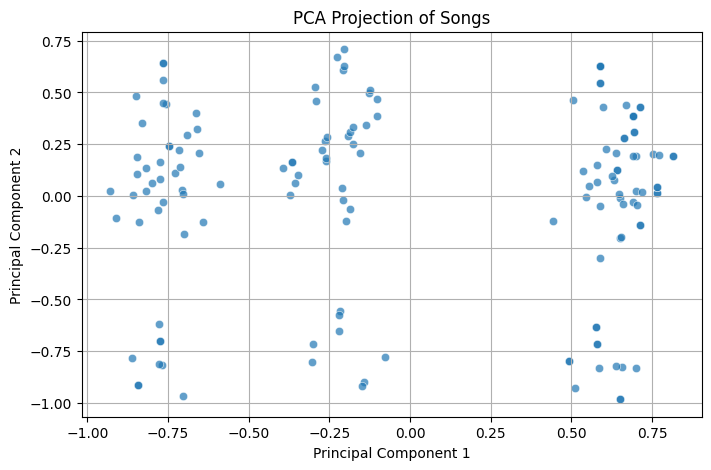

In [66]:
def pca_manual(X, num_components=2):
    """Performs PCA by computing eigenvectors of the covariance matrix."""
    X_centered = X - np.mean(X, axis=0)  # Centering the data
    covariance_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    principal_components = eigenvectors[:, sorted_indices[:num_components]]
    reduced_data = np.dot(X_centered, principal_components)
    return reduced_data
reduced_vectors = pca_manual(bow_matrix, num_components=2)
df_pca = pd.DataFrame(reduced_vectors, columns=["PC1", "PC2"])
df = pd.concat([df, df_pca], axis=1)
print("🔍 PCA Transformation (First 5 rows):")
display(df_pca.head(5))
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], alpha=0.7)
plt.title("PCA Projection of Songs")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

Cluster Assignments (First 5 Rows):


,song_id,PC1,PC2,Cluster
0,74,0.657688,-0.824515,1
1,103,-0.102039,0.388480,3
2,201,-0.078025,-0.776587,2
3,194,-0.654589,0.206701,3
4,184,-0.747081,0.241090,3


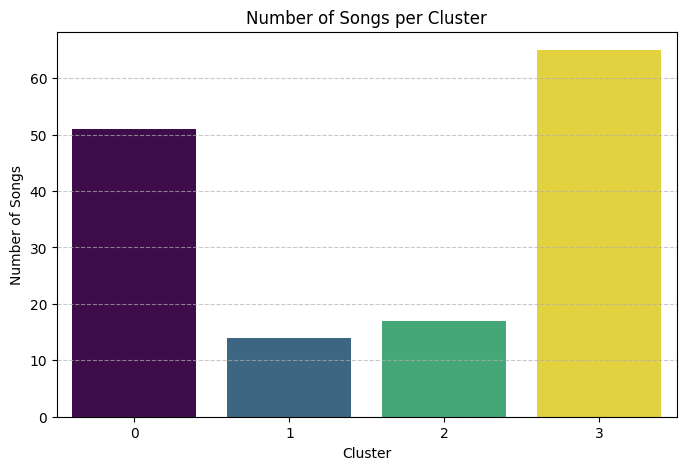

In [67]:
def k_means_custom(data, num_clusters=3, max_iterations=100, tolerance=1e-4):
    """Implements K-Means clustering without using sklearn."""
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], num_clusters, replace=False)]

    for iteration in range(max_iterations):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        clusters = np.argmin(distances, axis=1)
        new_centroids = np.array([data[clusters == i].mean(axis=0) for i in range(num_clusters)])
        if np.allclose(centroids, new_centroids, atol=tolerance):
            break
        centroids = new_centroids
    return clusters, centroids
clusters, centroids = k_means_custom(reduced_vectors, num_clusters=4)
df['Cluster'] = clusters
print("Cluster Assignments (First 5 Rows):")
display(df[['song_id', 'PC1', 'PC2', 'Cluster']].head())
cluster_counts = df['Cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette="viridis", legend=False)
plt.title("Number of Songs per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Songs")
plt.xticks(range(len(cluster_counts)))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

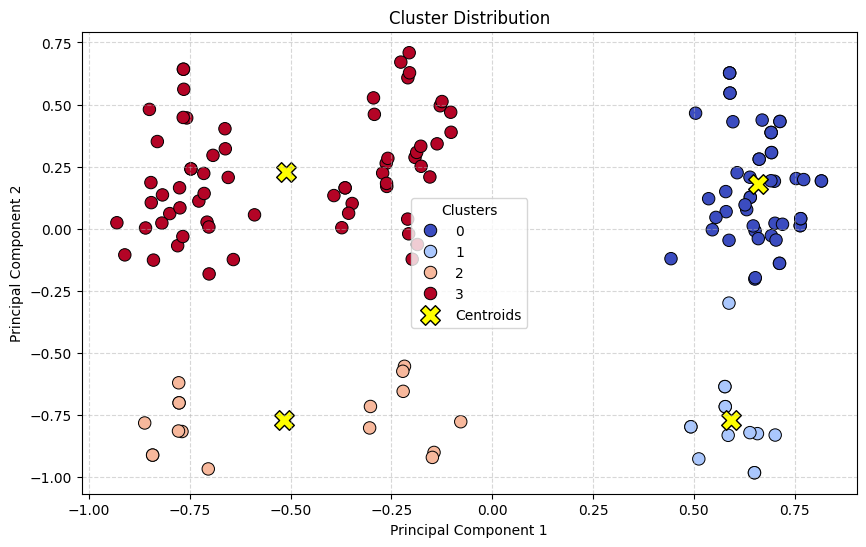

In [68]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_vectors[:, 0], y=reduced_vectors[:, 1], hue=df['Cluster'], palette='coolwarm', s=80, edgecolor='black')
plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', marker='X', s=200, edgecolor='black', label='Centroids')
plt.title("Cluster Distribution")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Clusters")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [69]:
def silhouette_score_manual(data, labels):
    def euclidean_distance(x, y):
        return np.sqrt(np.sum((x - y) ** 2))
    silhouette_values = []
    for i in range(len(data)):
        same_cluster = data[labels == labels[i]]
        other_clusters = data[labels != labels[i]]
        a = np.mean([euclidean_distance(data[i], point) for point in same_cluster]) if len(same_cluster) > 1 else 0
        b = np.min([np.mean([euclidean_distance(data[i], point) for point in other_clusters])]) if len(other_clusters) > 0 else 0
        silhouette = (b - a) / max(a, b) if max(a, b) > 0 else 0
        silhouette_values.append(silhouette)
    return np.mean(silhouette_values)
sil_score = silhouette_score_manual(reduced_vectors, clusters)
print(f"📊 Silhouette Score: {sil_score:.3f}")

📊 Silhouette Score: 0.706


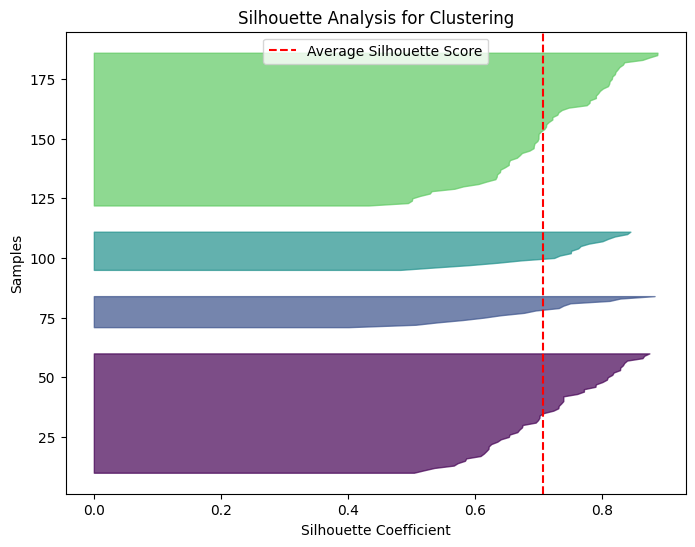

In [70]:
import matplotlib.cm as cm
silhouette_vals = []
for i in range(len(reduced_vectors)):
    same_cluster = reduced_vectors[clusters == clusters[i]]
    other_clusters = reduced_vectors[clusters != clusters[i]]
    a = np.mean([np.linalg.norm(reduced_vectors[i] - point) for point in same_cluster]) if len(same_cluster) > 1 else 0
    b = np.min([np.mean([np.linalg.norm(reduced_vectors[i] - point) for point in other_clusters])]) if len(other_clusters) > 0 else 0
    silhouette = (b - a) / max(a, b) if max(a, b) > 0 else 0
    silhouette_vals.append(silhouette)
silhouette_vals = np.array(silhouette_vals)
sorted_silhouette = np.sort(silhouette_vals)
num_clusters = len(set(clusters))
plt.figure(figsize=(8, 6))
y_lower = 10
for i in range(num_clusters):
    cluster_silhouette_vals = sorted_silhouette[clusters == i]
    size = len(cluster_silhouette_vals)
    y_upper = y_lower + size
    color = cm.viridis(float(i) / num_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, color=color, alpha=0.7)
    y_lower = y_upper + 10
plt.axvline(x=sil_score, color="red", linestyle="--", label="Average Silhouette Score")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Samples")
plt.title("Silhouette Analysis for Clustering")
plt.legend()
plt.show()

In [71]:
def weighted_keyword_vectorization(df):
    keyword_weights = [1.5, 1.2, 1.0]
    keywords = df[['keyword_1', 'keyword_2', 'keyword_3']].astype(str).values
    unique_words = sorted(set(keywords.flatten()))
    vocab = {word: i for i, word in enumerate(unique_words)}
    matrix = np.zeros((len(df), len(vocab)))
    for i, row in enumerate(keywords):
        for j, word in enumerate(row):
            if word in vocab:
                matrix[i, vocab[word]] += keyword_weights[j]
    row_norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    row_norms[row_norms == 0] = 1  # Avoid division by zero
    matrix /= row_norms
    return matrix, vocab
custom_vectors, custom_vocab = weighted_keyword_vectorization(df)
print("🔹 First 5 weighted keyword vectors:")
print(pd.DataFrame(custom_vectors[:5], columns=custom_vocab.keys()))

🔹 First 5 weighted keyword vectors:
   acoustic  angry     banjo     brass  calm  danceable  distorted  emotional  \
0  0.000000    0.0  0.000000  0.000000   0.0        0.0   0.461757        0.0   
1  0.000000    0.0  0.000000  0.692636   0.0        0.0   0.000000        0.0   
2  0.461757    0.0  0.692636  0.000000   0.0        0.0   0.000000        0.0   
3  0.000000    0.0  0.000000  0.000000   0.0        0.0   0.000000        0.0   
4  0.000000    0.0  0.000000  0.000000   0.0        0.0   0.000000        0.0   

   energetic  fast  ...   melodic  nostalgic  piano  rhythmic  sad      slow  \
0   0.000000   0.0  ...  0.000000        0.0    0.0       0.0  0.0  0.000000   
1   0.554109   0.0  ...  0.461757        0.0    0.0       0.0  0.0  0.000000   
2   0.000000   0.0  ...  0.000000        0.0    0.0       0.0  0.0  0.000000   
3   0.554109   0.0  ...  0.000000        0.0    0.0       0.0  0.0  0.000000   
4   0.554109   0.0  ...  0.000000        0.0    0.0       0.0  0.0  0.461757 

In [72]:
def pca_manual(X, num_components=2):
    """
    Performs PCA using eigen decomposition.
    """
    X_centered = X - np.mean(X, axis=0)
    covariance_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_eigenvectors = eigenvectors[:, sorted_indices[:num_components]]
    reduced_data = np.dot(X_centered, top_eigenvectors)
    return reduced_data
pca_vectors = pca_manual(custom_vectors, 2)
df_pca = pd.DataFrame(pca_vectors, columns=["PC1", "PC2"])
df_pca["Genre"] = df["genre"]
print("🔹 PCA-Reduced Vectors (First 5):")
print(df_pca.head())

🔹 PCA-Reduced Vectors (First 5):
        PC1       PC2      Genre
0  0.442620 -0.105457       rock
1 -0.097621  0.342518  classical
2 -0.091163  0.262445    country
3 -0.498809 -0.347262    hip-hop
4 -0.519362 -0.240028    hip-hop


In [73]:
def k_means_custom(data, num_clusters=3, max_iterations=100):
    """
    Implements K-Means clustering from scratch.
    """
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], num_clusters, replace=False)]

    for _ in range(max_iterations):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        clusters = np.argmin(distances, axis=1)
        new_centroids = np.array([data[clusters == i].mean(axis=0) for i in range(num_clusters)])
        if np.allclose(centroids, new_centroids, atol=1e-4):
            break
        centroids = new_centroids
    return clusters, centroids
clusters, centroids = k_means_custom(pca_vectors, num_clusters=3)
df_pca["Cluster"] = clusters
print("🔹 Clustered Data (First 5):")
print(df_pca.head())

🔹 Clustered Data (First 5):
        PC1       PC2      Genre  Cluster
0  0.442620 -0.105457       rock        1
1 -0.097621  0.342518  classical        0
2 -0.091163  0.262445    country        0
3 -0.498809 -0.347262    hip-hop        2
4 -0.519362 -0.240028    hip-hop        2


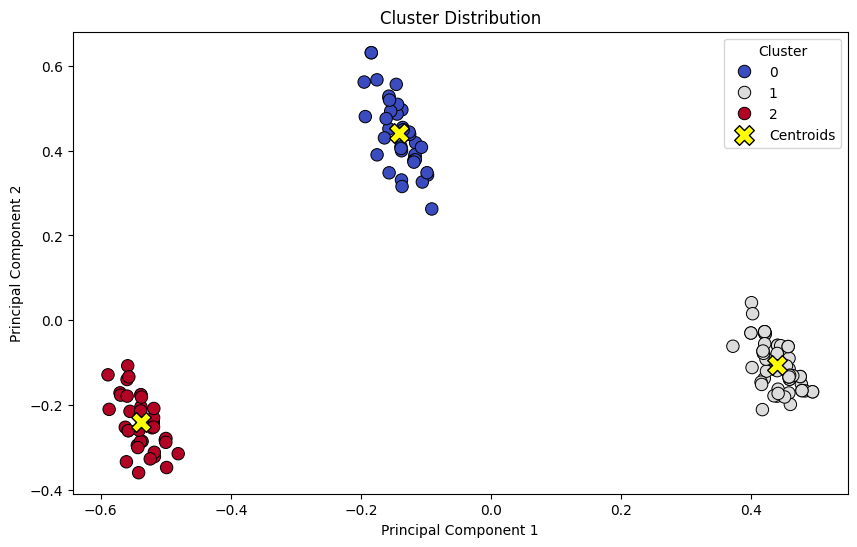

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_vectors[:, 0], y=pca_vectors[:, 1], hue=df_pca["Cluster"], palette="coolwarm", s=80, edgecolor="black")
plt.scatter(centroids[:, 0], centroids[:, 1], c="yellow", marker="X", s=200, edgecolor="black", label="Centroids")
plt.title("Cluster Distribution")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

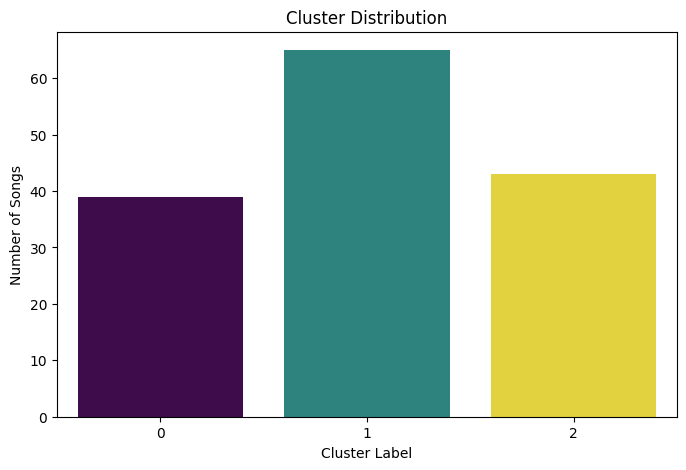

In [75]:
cluster_counts = df_pca["Cluster"].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette="viridis", legend=False)
plt.title("Cluster Distribution")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Songs")
plt.show()

In [76]:
def silhouette_score_manual(data, labels):
    def euclidean_distance(a, b):
        return np.sqrt(np.sum((a - b) ** 2))
    silhouette_values = []
    for i in range(len(data)):
        same_cluster = data[labels == labels[i]]
        other_clusters = data[labels != labels[i]]
        a = np.mean([euclidean_distance(data[i], point) for point in same_cluster]) if len(same_cluster) > 1 else 0
        b = np.min([np.mean([euclidean_distance(data[i], point) for point in other_clusters])]) if len(other_clusters) > 0 else 0
        silhouette = (b - a) / max(a, b) if max(a, b) > 0 else 0
        silhouette_values.append(silhouette)
    return np.mean(silhouette_values)
combined_embedding = np.mean(reduced_vectors, axis=1, keepdims=True)
sil_score = silhouette_score_manual(combined_embedding, clusters)
print(f"📊 Silhouette Score: {sil_score:.3f}")

📊 Silhouette Score: 0.462


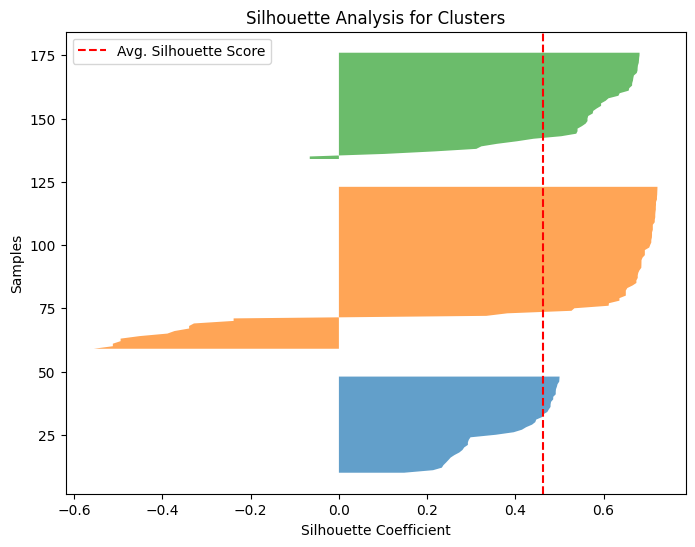

In [77]:
def compute_silhouette_values(data, labels):
    def euclidean_distance(x, y):
        return np.sqrt(np.sum((x - y) ** 2))
    silhouette_vals = []
    for i in range(len(data)):
        same_cluster = data[labels == labels[i]]
        other_clusters = data[labels != labels[i]]
        a = np.mean([euclidean_distance(data[i], point) for point in same_cluster]) if len(same_cluster) > 1 else 0
        b = np.min([np.mean([euclidean_distance(data[i], point) for point in other_clusters])]) if len(other_clusters) > 0 else 0
        silhouette = (b - a) / max(a, b) if max(a, b) > 0 else 0
        silhouette_vals.append(silhouette)
    return np.array(silhouette_vals)
silhouette_values = compute_silhouette_values(combined_embedding, clusters)
plt.figure(figsize=(8, 6))
sorted_silhouette = silhouette_values.copy()
y_lower = 10
for i in range(num_clusters):
    cluster_silhouette_vals = sorted_silhouette[clusters == i]
    cluster_silhouette_vals.sort()
    size = len(cluster_silhouette_vals)
    y_upper = y_lower + size
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals, alpha=0.7)
    y_lower = y_upper + 10
plt.axvline(x=sil_score, color="red", linestyle="--", label="Avg. Silhouette Score")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Samples")
plt.title("Silhouette Analysis for Clusters")
plt.legend()
plt.show()

In [78]:
import numpy as np
def euclidean_distance_matrix(data):
    num_points = data.shape[0]
    dist_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            dist_matrix[i, j] = np.linalg.norm(data[i] - data[j])
    return dist_matrix
def dunn_index(data, labels):
    unique_clusters = np.unique(labels)
    intra_cluster_distances = []
    inter_cluster_distances = []
    for cluster in unique_clusters:
        cluster_points = data[labels == cluster]
        if len(cluster_points) > 1:
            intra_dist = np.max(euclidean_distance_matrix(cluster_points))
            intra_cluster_distances.append(intra_dist)
    for i in unique_clusters:
        for j in unique_clusters:
            if i != j:
                cluster_i = data[labels == i]
                cluster_j = data[labels == j]
                min_dist = np.min([np.linalg.norm(p1 - p2) for p1 in cluster_i for p2 in cluster_j])
                inter_cluster_distances.append(min_dist)
    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)
def davies_bouldin_index(data, labels):
    unique_clusters = np.unique(labels)
    cluster_centers = np.array([data[labels == c].mean(axis=0) for c in unique_clusters])
    cluster_spreads = np.array([np.mean([np.linalg.norm(p - cluster_centers[i]) for p in data[labels == c]]) for i, c in enumerate(unique_clusters)])
    db_values = []
    for i in range(len(unique_clusters)):
        max_ratio = 0
        for j in range(len(unique_clusters)):
            if i != j:
                separation = np.linalg.norm(cluster_centers[i] - cluster_centers[j])
                spread_ratio = (cluster_spreads[i] + cluster_spreads[j]) / separation
                max_ratio = max(max_ratio, spread_ratio)
        db_values.append(max_ratio)
    return np.mean(db_values)
dunn = dunn_index(combined_embedding, clusters)
davies_bouldin = davies_bouldin_index(combined_embedding, clusters)
print(f"📌 Dunn Index: {dunn:.3f}")
print(f"📌 Davies-Bouldin Index: {davies_bouldin:.3f}")

📌 Dunn Index: 0.000
📌 Davies-Bouldin Index: 1.089


In [79]:
import numpy as np
np.random.seed(42)
ground_truth_labels = np.random.randint(0, 5, size=len(clusters))
def adjusted_rand_index(true_labels, pred_labels):
    from scipy.special import comb
    contingency = np.zeros((np.max(true_labels) + 1, np.max(pred_labels) + 1))
    for t, p in zip(true_labels, pred_labels):
        contingency[t, p] += 1
    sum_comb = lambda x: np.sum(comb(x, 2))
    a = np.sum(comb(np.sum(contingency, axis=1), 2))
    b = np.sum(comb(np.sum(contingency, axis=0), 2))
    c = np.sum(comb(contingency.flatten(), 2))
    d = comb(len(true_labels), 2)
    return (c - (a * b) / d) / (0.5 * (a + b) - (a * b) / d)
def entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return -np.sum(probabilities * np.log2(probabilities))
def mutual_information(true_labels, pred_labels):
    contingency = np.zeros((np.max(true_labels) + 1, np.max(pred_labels) + 1))
    for t, p in zip(true_labels, pred_labels):
        contingency[t, p] += 1
    joint_prob = contingency / len(true_labels)
    true_prob = np.sum(joint_prob, axis=1)
    pred_prob = np.sum(joint_prob, axis=0)
    mi = np.nansum(joint_prob * np.log2(joint_prob / (true_prob[:, None] * pred_prob[None, :])))
    return mi
def normalized_mutual_information(true_labels, pred_labels):
    mi = mutual_information(true_labels, pred_labels)
    return mi / np.sqrt(entropy(true_labels) * entropy(pred_labels))
ari_score = adjusted_rand_index(ground_truth_labels, clusters)
nmi_score = normalized_mutual_information(ground_truth_labels, clusters)
print(f"📌 Adjusted Rand Index (ARI): {ari_score:.3f}")
print(f"📌 Normalized Mutual Information (NMI): {nmi_score:.3f}")

📌 Adjusted Rand Index (ARI): -0.008
📌 Normalized Mutual Information (NMI): 0.014
